## Overview 
1. Data analysis of given data
2. Check Covariance
3. ??

# 1.Data analysis of given data
The goal of this analysis is to visulaize and clean if neccessay ... 

In [50]:
# import packages 
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt

# import data
dwd_demand = nc.Dataset("data/dwd_icon_eu_demand_20200920_20231027.nc")
dwd_hornsea = nc.Dataset("data/dwd_icon_eu_hornsea_1_20200920_20231027.nc")
dwd_pes10 = nc.Dataset("data/dwd_icon_eu_pes10_20200920_20231027.nc")
ncep_demand = nc.Dataset("data/ncep_gfs_demand_20200920_20231027.nc")
ncep_hornsea = nc.Dataset("data/ncep_gfs_hornsea_1_20200920_20231027.nc")
ncep_pes10 = nc.Dataset("data/ncep_gfs_pes10_20200920_20231027.nc")

datasets = {
    "DWD Demand": dwd_demand,
    "DWD Hornsea": dwd_hornsea,
    "DWD PES10": dwd_pes10,
    "NCEP Demand": ncep_demand,
    "NCEP Hornsea": ncep_hornsea,
    "NCEP PES10": ncep_pes10
}

# Explore data, look at variables, dimensions ect.

In [51]:
# Show variables, dimensions, shapes, and units of a dataset 
def describe_nc_dataset(dataset, dataset_name):
    print("\nOverview of " + dataset_name)   
    for var in dataset.variables.values():
        name = var.name 
        dims = var.dimensions
        shape = var.shape
        units = var.units if 'units' in var.ncattrs() else 'N/A'
        print(f"{name}: {dims} {shape} {units}")

for name, ds in datasets.items():
    describe_nc_dataset(ds, name)


Overview of DWD Demand
RelativeHumidity: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
Temperature: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
TotalPrecipitation: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
WindDirection: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
WindSpeed: ('ref_datetime', 'valid_datetime', 'point') (4467, 93, 7) N/A
latitude: ('point',) (7,) N/A
longitude: ('point',) (7,) N/A
point: ('point',) (7,) N/A
ref_datetime: ('ref_datetime',) (4467,) hours since 2022-09-18T06:00:00
valid_datetime: ('valid_datetime',) (93,) N/A

Overview of DWD Hornsea
RelativeHumidity: ('ref_datetime', 'valid_datetime', 'latitude', 'longitude') (4467, 93, 6, 6) N/A
Temperature: ('ref_datetime', 'valid_datetime', 'latitude', 'longitude') (4467, 93, 6, 6) N/A
WindDirection: ('ref_datetime', 'valid_datetime', 'latitude', 'longitude') (4467, 93, 6, 6) N/A
WindDirection:100: ('ref_datetime', 'valid_datetime', 'latitude', 'lo

# Check Time

In [52]:
def inspect_time(dataset, dataset_name):
    print(f"\nTime details for {dataset_name}:")
    time_var = dataset.variables['ref_datetime']
    print(f"  Units: {time_var.units}")
    print(f"  Start: {nc.num2date(time_var[0], time_var.units)}")
    print(f"  End: {nc.num2date(time_var[-1], time_var.units)}")
    print(f"  Frequency: {(nc.num2date(time_var[1], time_var.units) - nc.num2date(time_var[0], time_var.units))}")

for name, ds in datasets.items():
    inspect_time(ds, name)


Time details for DWD Demand:
  Units: hours since 2022-09-18T06:00:00
  Start: 2020-09-20 00:00:00
  End: 2023-10-27 00:00:00
  Frequency: 6:00:00

Time details for DWD Hornsea:
  Units: hours since 2022-09-18T06:00:00
  Start: 2020-09-20 00:00:00
  End: 2023-10-27 00:00:00
  Frequency: 6:00:00

Time details for DWD PES10:
  Units: hours since 2022-09-18T06:00:00
  Start: 2020-09-20 00:00:00
  End: 2023-10-27 00:00:00
  Frequency: 6:00:00

Time details for NCEP Demand:
  Units: hours since 2020-11-12T06:00:00
  Start: 2020-09-20 00:00:00
  End: 2023-10-27 00:00:00
  Frequency: 6:00:00

Time details for NCEP Hornsea:
  Units: hours since 2020-11-12T06:00:00
  Start: 2020-09-20 00:00:00
  End: 2023-10-27 00:00:00
  Frequency: 6:00:00

Time details for NCEP PES10:
  Units: hours since 2021-01-11T12:00:00
  Start: 2020-09-20 00:00:00
  End: 2023-10-27 00:00:00
  Frequency: 6:00:00


# Check Missing Values 

In [53]:
# Function to check missing values in a dataset
def check_missing_values(dataset):
    for var_name, var in dataset.variables.items():
        if var.ndim >= 2 and var.dtype.kind in 'fiu':
            data = var[:]
            fill_value = var._FillValue if '_FillValue' in var.ncattrs() else None
            n_missing = np.isnan(data).sum()
            if fill_value is not None:
                n_missing += np.sum(data == fill_value)
            print(f"{var_name}: Missing = {n_missing}")


check_missing_values(dwd_demand)

RelativeHumidity: Missing = 0
Temperature: Missing = 0
TotalPrecipitation: Missing = 0
WindDirection: Missing = 0
WindSpeed: Missing = 0


# Visualize Data

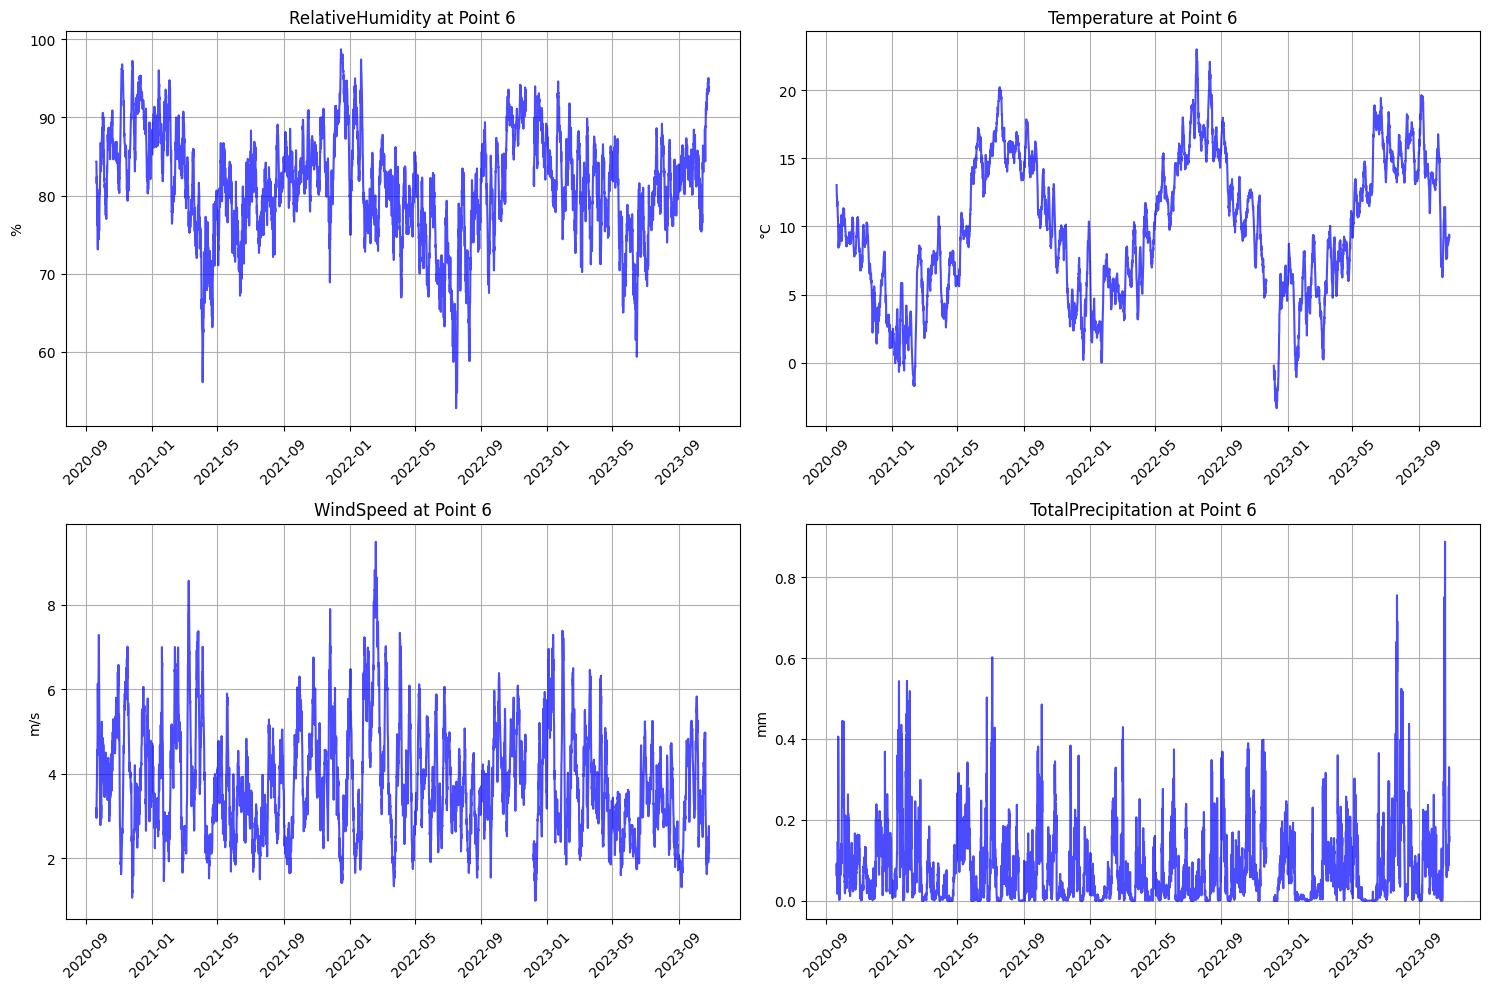

In [57]:
from datetime import datetime

# Configuration
point_idx = 6  # Which location to plot (0-6)
variables = ['RelativeHumidity', 'Temperature', 'WindSpeed', 'TotalPrecipitation']
units = ['%', '°C', 'm/s', 'mm']

# Create figure
plt.figure(figsize=(15, 10))

# Convert reference times to datetime
ref_times = nc.num2date(dwd_demand.variables['ref_datetime'][:],
                       dwd_demand.variables['ref_datetime'].units)
ref_times_datetime = [datetime(rt.year, rt.month, rt.day, rt.hour) for rt in ref_times]

# Plot each variable
for i, (var, unit) in enumerate(zip(variables, units), 1):
    # Get and aggregate data
    data = dwd_demand.variables[var][:, :, point_idx]  # [ref, valid, point]
    mean_values = np.nanmean(data, axis=1)  # Handles any NaN values
    
    # Create subplot
    plt.subplot(2, 2, i)
    plt.plot(ref_times_datetime, mean_values, 'b-', alpha=0.7)
    plt.title(f'{var} at Point {point_idx}')
    plt.ylabel(unit)
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

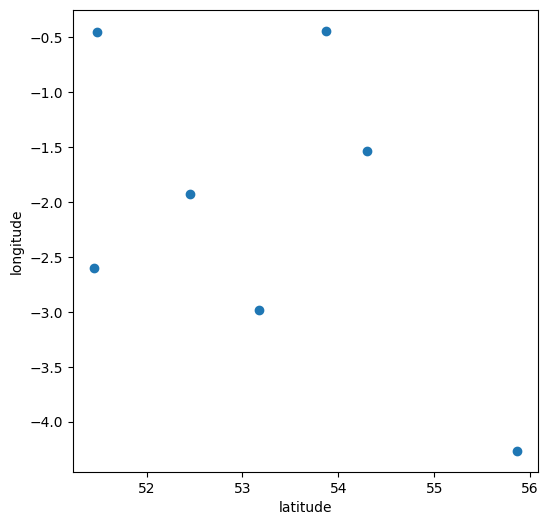

AttributeError: NetCDF: Attribute not found

In [ ]:
points = dwd_demand.variables['point'][:] # 0 1 2 3 4 5 6 
lats = dwd_demand.variables['latitude'][:]
lons = dwd_demand.variables['longitude'][:]

# Plot latitide and longitude
plt.figure(figsize=(6, 6))
plt.plot(lats, lons, 'o')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()
